In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from scipy.ndimage import convolve
import time
from PIL import Image
import os

(675, 900, 3)


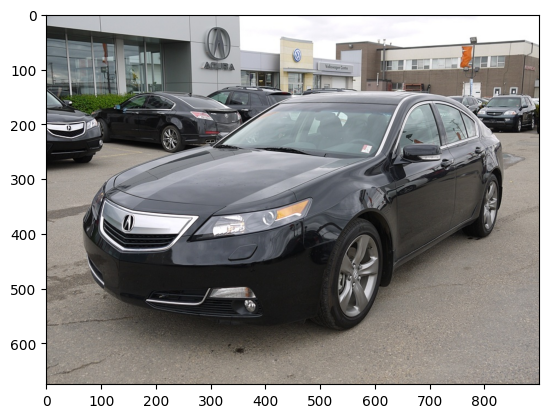

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
imgorg = Image.open('../Cars/Original/00002.jpg')
# imgorg = Image.open('img1.jpg')
imgorg = np.array(imgorg)
print(imgorg.shape)
img = rgb2gray(imgorg)
plt.imshow(imgorg)
plt.show()

In [5]:
kernel0 = np.array([
                [-1, 0.0, 1],
                [-2, 0.0, 2],
                [-1, 0.0, 1]])
kernel1= np.array([
                [-1,-2,-1],
                [0.0,0.0,0.0],
                [1,2,1]])

def convolve_img(img, kernel):
    return convolve(img, kernel) 

In [6]:
def partial_derivative(img):
    grx = convolve_img(img, kernel0)
    gry = convolve_img(img, kernel1)
    return grx, gry

def get_edgeness(img):
    grx, gry = partial_derivative(img)
    maxx = float('-inf')
    edged = [[ 0 for _ in range(len(grx[0]))] for _ in range(len(grx))]
    for i in range(len(grx)):
        for j in range(len(grx[0])):
            edged[i][j] = ((grx[i][j])**2  + (gry[i][j])**2)**0.5
            if edged[i][j] > maxx:
                maxx = edged[i][j]
    
    for i in range(len(grx)):
        for j in range(len(grx[0])):
            edged[i][j] /= maxx
    return edged

def least_edgy_ver(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img[0])):
        least_e[-1][i] = edged_img[-1][i]
    m, n = len(edged_img), len(edged_img[0])

    for i in range(m-2,-1,-1):
        for j in range(n):
            j1, j2 = max(0, j-1), min(j+1, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(least_e[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            least_e[i][j] = edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (j==0)]

    return least_e, dirs

def least_edgy_hor(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img)):
        least_e[i][-1] = edged_img[i][-1]
    m, n = len(edged_img), len(edged_img[0])
    for j in range(n-2, -1, -1):
        for i in range(m):
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(least_e[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            least_e[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (i==0)]
    return least_e, dirs


def get_seam_at_ver(dirs, j):
    m = len(dirs)
    js = [0 for _ in range(m)]
    js[0] = j
    for i in range(1, m):
        js[i] = js[i-1]+dirs[i-1][int(js[i-1])]
    return js

def get_seam_at_hor(dirs, i):
    n = len(dirs[0])
    js = [0 for _ in range(n)]
    js[0] = i
    for j in range(1, n):
        js[j] = js[j-1] + dirs[int(js[j-1])][j-1]

    return js

def rm_path_ver(img, path):
    img = np.array(img)
    n = len(img[0])
    cut_img = img[:, :-1].copy()

    for i, j in enumerate(path):
        j = int(j)
        cut_img[i,:j] = img[i,:j]
        cut_img[i,j:] = img[i,j+1:]

    return cut_img

def rm_path_hor(img, path):
    img = np.array(img)
    m = len(img)
    cut_img = img[:-1, :].copy()
    # print(len(cut_img), len(img))
    for i, j in enumerate(path):
        #i is col and j is row here
        j = int(j)
        cut_img[:j,i] = img[:j,i]
        cut_img[j:,i] = img[j+1:,i]

    return cut_img

def shrink_horizontally1(img,edged,org, n):
    new_img = np.copy(img)
    org_i = np.copy(org)
    for i in range(n):  
        dp, dirs = least_edgy_ver(edged)
        m_col = float('inf')
        col = 0
        for j in range(0,len(dp[0])):
            if m_col > dp[0][j]:
                m_col = dp[0][j]
                col = j 
        seam = get_seam_at_ver(dirs, col)
        new_img = rm_path_ver(new_img, seam)
        org_i = rm_path_ver(org_i, seam)
        edged = rm_path_ver(edged, seam)

    return new_img, org_i
def recompute_dir_neighbours_ver(seam, dirs, dp, edged_img):
    m = len(dp)
    n = len(dp[0])
    for i in range(len(seam)-2, -1,-1):
        j = int(seam[i])
        if j == 0:
            # If we removed 0 column then we have to update 0 column
            j1, j2 = 0, 1
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][0] += edged_img[i][0]+min_e
            dirs[i][0] = (0,1)[direction]
        elif j == n:
            j = j-1
            # If we removed n-1 column then we have to update n-1 column
            j1, j2 = j-1, j
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1, 0)[direction]
        else:
            if j-1>=0:
                j1, j2 = max(0, j-2), min(j, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j-1] += edged_img[i][j-1] + min_e
                dirs[i][j-1] = (-1,0,1)[direction + ((j-1)==0)]
            if j<n-1:
                j1, j2 = max(0, j-1), min(j+1, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j] += edged_img[i][j] + min_e
                dirs[i][j] = (-1,0,1)[direction + (j==0)]
            
        
    return dp, dirs
def recompute_dir_neighbours_hor(seam, dirs, dp, edged):
    m = len(dirs)
    n = len(dirs[0])
    for j in range(len(seam)-2,-1,-1):
        i = int(seam[j])
        if i == 0:
            i1, i2 = 0, 1
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[0][j] += edged[0][j] + min_e
            dirs[0][j] = (0,1)[direction]
        elif i == m:
            i = i-1
            i1, i2 = i-1, i
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0)[direction]
        else:
            i1, i2 = max(0, i-2), min(i, m-1)
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i-1][j] += edged[i-1][j] + min_e
            dirs[i-1][j] = (-1,0,1)[direction+((i-1)==0)]
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction+(i==0)]
        
    return dp, dirs
def shrink_horizontally(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    dp, dirs = least_edgy_ver(edged)
    for i in range(n):  
        col = np.argmin(dp[0])
        seam = get_seam_at_ver(dirs, col)
        new_img = rm_path_ver(new_img, seam)
        org_img = rm_path_ver(org_img, seam)
        dp = rm_path_ver(dp, seam)
        dirs = rm_path_ver(dirs, seam)
        # edged = get_edgeness(new_img)
        edged = rm_path_ver(edged, seam)
        dp, dirs = recompute_dir_neighbours_ver(seam,dirs,dp,edged)

    return new_img, org_img


    
def shrink_vertically(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    dp, dirs = least_edgy_hor(edged)
    for i in range(n):
        row = np.argmin(dp[:,0])
        seam = get_seam_at_hor(dirs, row)
        new_img = rm_path_hor(new_img, seam)
        org_img = rm_path_hor(org_img, seam)
        dp = rm_path_hor(dp, seam)
        dirs = rm_path_hor(dirs, seam)
        edged = rm_path_hor(edged, seam)
        dp, dirs = recompute_dir_neighbours_hor(seam, dirs, dp, edged)

    return new_img, org_img

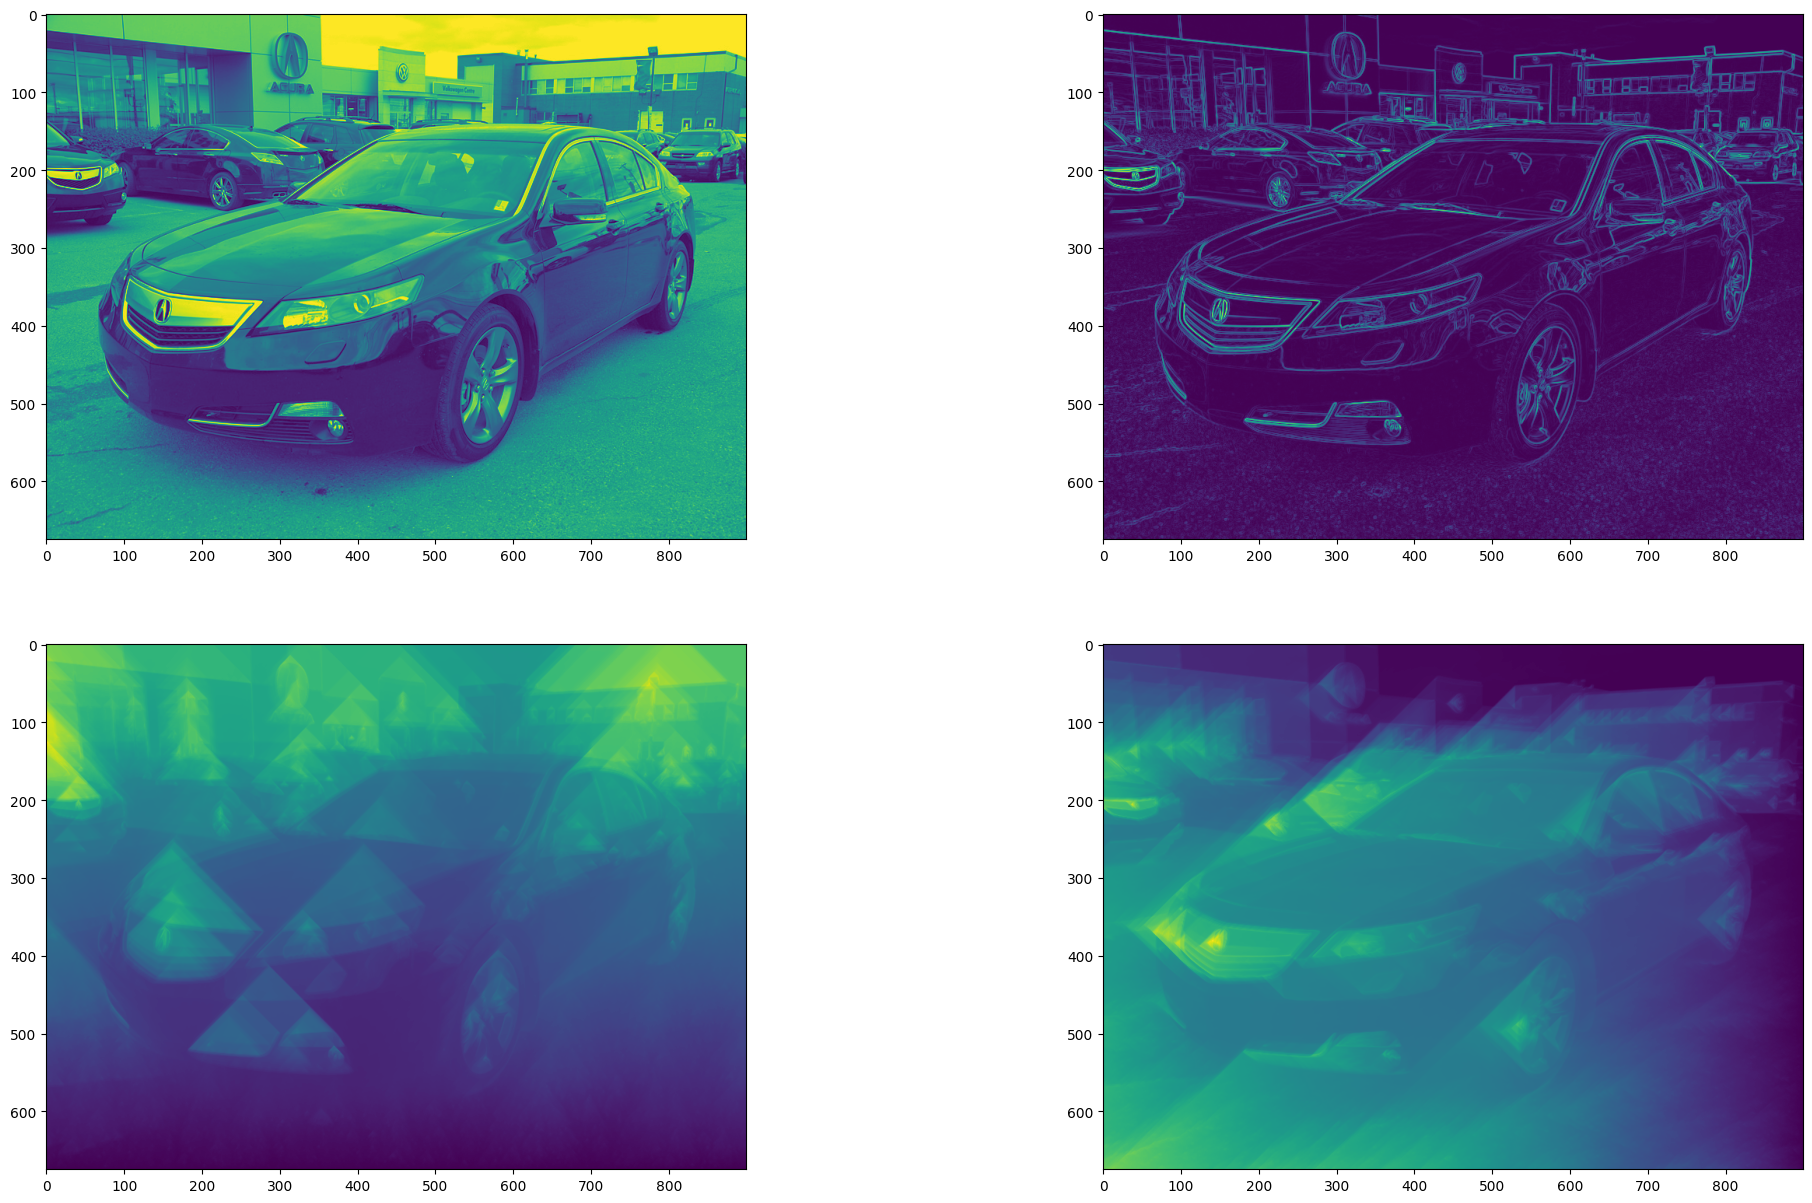

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
edged = get_edgeness(img)
dp1, dirs1 = least_edgy_ver(edged)
dp2, dirs2 = least_edgy_hor(edged)
axes[0][0].imshow(img)
axes[0][1].imshow(edged)
axes[1][0].imshow(dp1)
axes[1][1].imshow(dp2)

It took 5s to shrink horizontally by 192px and vertically by 108px


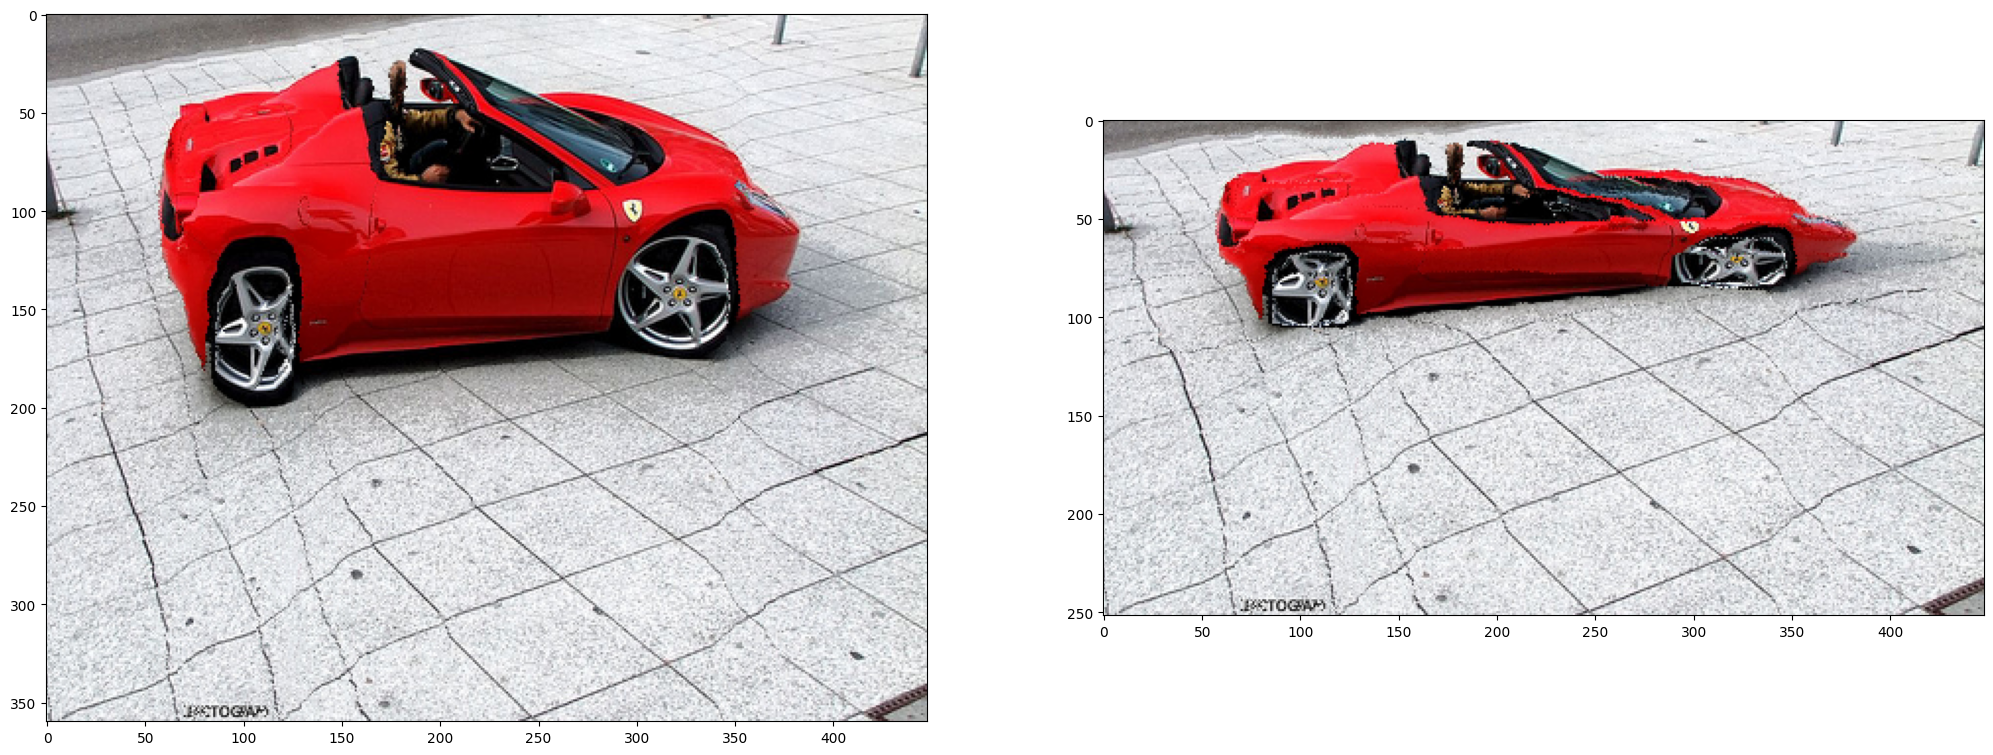

In [27]:
scale = 0.3
horPx = round(img.shape[1] * scale)
verPx = round(img.shape[0] * scale)
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
start = time.time() 
edged = get_edgeness(img)
img1 = shrink_horizontally(img,edged,imgorg,horPx)
edged = get_edgeness(img1[0])
img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
img_from_array = Image.fromarray(img2[1])
img_from_array.save("new_image.jpg")
axes[0].imshow(img1[1])
axes[1].imshow(img2[1])
end = time.time()
print("It took "+str(round(end - start))+"s to shrink horizontally by "+str(horPx)+"px and vertically by "+str(verPx)+"px")

In [1]:
def compute_transport_map(img, edged, r_max, c_max):
    """
    Computes the transport map for optimal seam carving.
    :param img: Input image.
    :param edged: Energy map of the image.
    :param r_max: Number of horizontal seams to remove.
    :param c_max: Number of vertical seams to remove.
    :return: Transport map T and the decision map for backtracking.
    """
    T = np.zeros((r_max + 1, c_max + 1))  # Transport map
    decision = np.zeros((r_max + 1, c_max + 1), dtype=int)  # Decision map (0: horizontal, 1: vertical)

    # Initialize horizontal base case (T[r, 0])
    dp_hor, dirs_hor = least_edgy_hor(edged)  # Compute once
    for r in range(1, r_max + 1):
        seam_cost = np.min(dp_hor[:r, 0])  # Consider only the first r rows
        T[r, 0] = T[r-1, 0] + seam_cost
        decision[r, 0] = 0  # Horizontal seam

    # Initialize vertical base case (T[0, c])
    dp_ver, dirs_ver = least_edgy_ver(edged)  # Compute once
    for c in range(1, c_max + 1):
        seam_cost = np.min(dp_ver[0, :c])  # Consider only the first c columns
        T[0, c] = T[0, c-1] + seam_cost
        decision[0, c] = 1  # Vertical seam

    # Fill the transport map
    for r in range(1, r_max + 1):
        for c in range(1, c_max + 1):
            # Compute seam costs for horizontal and vertical removals
            seam_cost_hor = np.min(dp_hor[:r, 0])  # First r rows for horizontal
            seam_cost_ver = np.min(dp_ver[0, :c])  # First c columns for vertical

            # Dynamic programming recurrence
            if T[r-1, c] + seam_cost_hor < T[r, c-1] + seam_cost_ver:
                T[r, c] = T[r-1, c] + seam_cost_hor
                decision[r, c] = 0  # Horizontal seam
            else:
                T[r, c] = T[r, c-1] + seam_cost_ver
                decision[r, c] = 1  # Vertical seam

    return T, decision


def backtrack_transport_map(decision, r_max, c_max):
    """
    Backtracks the transport map to determine the optimal seam removal order.
    :param decision: Decision map from compute_transport_map.
    :param r_max: Rows removed.
    :param c_max: Columns removed.
    :return: List of seam removal operations (0: horizontal, 1: vertical).
    """
    r, c = r_max, c_max
    seam_order = []

    while r > 0 or c > 0:
        if decision[r, c] == 0:  # Horizontal seam
            seam_order.append(0)
            r -= 1
        else:  # Vertical seam
            seam_order.append(1)
            c -= 1

    return seam_order[::-1]  # Reverse to get the correct order

def apply_seam_carving(img, edged, seam_order,imgorg):
    """
    Applies seam carving in the optimal order with efficient updates.
    :param img: Input image.
    :param edged: Energy map.
    :param seam_order: List of seam removal operations (0: horizontal, 1: vertical).
    :return: Resized image.
    """
    imgorg = np.copy(imgorg)
    new_img = np.copy(img)
    new_edged = np.copy(edged)
    dp, dirs = least_edgy_ver(new_edged)
    dp_hr, dirs_hr = least_edgy_hor(new_edged)
    for op in seam_order:
        if op == 0:  # Remove horizontal seam
            dp_hr, dirs_hr = least_edgy_hor(new_edged)
            seam = get_seam_at_hor(dirs_hr, np.argmin(dp_hr[:, 0]))
            new_img = rm_path_hor(new_img, seam)
            dirs_hr = rm_path_hor(dirs_hr, seam)
            dp_hr = rm_path_hor(dp_hr, seam)

            dirs = rm_path_hor(dirs, seam)
            dp = rm_path_hor(dp, seam)
            
            new_edged = rm_path_hor(new_edged, seam)
            imgorg = rm_path_hor(imgorg, seam)
            dp_hr, dirs_hr = recompute_dir_neighbours_hor(seam,dirs_hr,dp_hr,new_edged)
            # Optionally, recalculate energy locally near the seam
            # new_edged = recompute_energy(new_img, seam, axis=0)
        else:  # Remove vertical seam
            dp, dirs = least_edgy_ver(new_edged)
            seam = get_seam_at_ver(dirs, np.argmin(dp[0, :]))
            new_img = rm_path_ver(new_img, seam)
            dirs = rm_path_ver(dirs, seam)
            dp = rm_path_ver(dp, seam)
            
            dirs_hr = rm_path_ver(dirs_hr, seam)
            dp_hr = rm_path_ver(dp_hr, seam)
            
            new_edged = rm_path_ver(new_edged, seam)
            imgorg = rm_path_ver(imgorg, seam)
            dp, dirs = recompute_dir_neighbours_ver(seam,dirs,dp,new_edged)
            # Optionally, recalculate energy locally near the seam
            # new_edged = recompute_energy(new_img, seam, axis=1)

    return new_img,imgorg


In [ ]:
scale = 0.3
cols_to_remove = round(img.shape[1] * scale)
rows_to_remove = round(img.shape[0] * scale)
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
start = time.time() 
edged = get_edgeness(img)
T, decision = compute_transport_map(img, edged,rows_to_remove,cols_to_remove)
seam_order = backtrack_transport_map(decision, rows_to_remove, cols_to_remove)
newImg, org_img = apply_seam_carving(img, edged, seam_order, imgorg)
end = time.time()
axes[0].imshow(img2[1])
axes[1].imshow(org_img)
print("It took "+str(round(end - start))+"s to shrink horizontally by "+str(horPx)+"px and vertically by "+str(verPx)+"px")

In [1]:
count = 0
path = '../Cars/Original/'
savePath = '../Cars/Resized/'
start = time.time() 
for file in os.listdir(path):
    if file.split('.')[-1] != 'jpg':
        continue
    print("Processing file "+str(count+1)+":"+file)
    imgorg = Image.open(path+file)
    imgorg = np.array(imgorg)
    img = rgb2gray(imgorg)
    scale = 0.3
    horPx = round(img.shape[1] * scale)
    verPx = round(img.shape[0] * scale)
    edged = get_edgeness(img)
    img1 = shrink_horizontally(img,edged,imgorg,horPx)
    edged = get_edgeness(img1[0])
    img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
    final = np.transpose(processor(img2[1]).pixel_values[0], (1, 2, 0))
    final = final.astype(np.float)
    img_from_array = Image.fromarray(final)
    img_from_array.save(savePath+file.split('.')[0]+"_sc.jpg")
    count += 1
end = time.time()

print("Time taken to process "+str(count + 1)+" images ~ "+str(round((end-start)/60))+" mins")

NameError: name 'time' is not defined